# Data understanding

De gebruikte dataset is “Vestigingen_Gemeente" (https://opendata.cbs.nl/statline/#/CBS/nl/dataset/81575NED/table?ts=1584707583585). 

De CBS data is een csv bestand, dit staat voor comma seperated values of door comma gescheide waarden in het nederlands.
De data bevat de volgende kolomen:
 - `ID` is de unieke waarde voor elke row.
 - `Bedrijfstakken/branches SBI 2008` geeft de waarde weer in welke bedrijfstak/branch de bedrijfen zit.
 - `Perioden` geeft de periode aan waarin de bedrijfstak/branch actief in is.
 - `Regio's` is de regio waarin de behorende bedrijfstak/branch actief in is.
 - `Vestigingen (aantal)` is de aantal vestigingen die binnen die bedrijfstak/branch geteld zijn per regio en per periode.

## Beschrijven van de data

Hieronder staat een beschrijving van de data vanuit de Centraal Bureau Statistieken. Dit wordt telkens door middel van een stukje code weergegeven. 

In [43]:
import pandas as pd
import geopandas as gpd
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing
from prep import movecol

pd.set_option('display.max_rows', 50)

# Dataset inlezen
file = "../raw-data/Vestegingen_Gemeente.csv"
postcode_file = "../raw-data/provincie.xlsx"
data_pc = pd.read_excel(postcode_file)
data_vg = pd.read_csv(file, sep=";")

# Dataverkennen door dataframe te openen
data_vg

,Bedrijfstakken/branches SBI 2008,Perioden,Regio's,Vestigingen (aantal)
0,"A Landbouw, bosbouw en visserij",2013,Amsterdam,95
1,"A Landbouw, bosbouw en visserij",2014,Amsterdam,100
2,"A Landbouw, bosbouw en visserij",2015,Amsterdam,105
3,"A Landbouw, bosbouw en visserij",2016,Amsterdam,105
4,"A Landbouw, bosbouw en visserij",2017,Amsterdam,110
...,...,...,...,...
1933,U Extraterritoriale organisaties,2014,Zwolle,0
1934,U Extraterritoriale organisaties,2015,Zwolle,0
1935,U Extraterritoriale organisaties,2016,Zwolle,0
1936,U Extraterritoriale organisaties,2017,Zwolle,0


In [44]:
regios = data_vg["Regio's"].drop_duplicates()
regios

0                     Amsterdam
6                        Arnhem
12                        Assen
18                        Breda
24                    Eindhoven
30                     Enschede
36     's-Gravenhage (gemeente)
42         Groningen (gemeente)
48                      Haarlem
54             's-Hertogenbosch
60                   Leeuwarden
66                       Leiden
72                     Lelystad
78                   Maastricht
84              Middelburg (Z.)
90                    Rotterdam
96                      Tilburg
102          Utrecht (gemeente)
108                      Zwolle
Name: Regio's, dtype: object

In [45]:
data_pc

,Regio's,Provincie
0,Appingedam,Groningen
1,Bedum,Groningen
2,Bellingwedde,Groningen
3,Ten Boer,Groningen
4,Delfzijl,Groningen
...,...,...
454,Venlo,Limburg
455,Venray,Limburg
456,Voerendaal,Limburg
457,Weert,Limburg


In [46]:
# Info over de kolommen
groepeerde_data_vg = data_vg.groupby(["Regio's", "Perioden"]).sum()
info_kolommen_vg = data_vg.info()
info_kolommen_vg

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1938 entries, 0 to 1937
Data columns (total 4 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   Bedrijfstakken/branches SBI 2008  1938 non-null   object
 1   Perioden                          1938 non-null   int64 
 2   Regio's                           1938 non-null   object
 3   Vestigingen (aantal)              1938 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 60.7+ KB


In [47]:
# Beschrijvende statistieken van de data
beschrijvende_stats_vg = data_vg.describe()
beschrijvende_stats_vg

,Perioden,Vestigingen (aantal)
count,1938.000000,1938.000000
mean,2015.500000,1256.542828
std,1.708266,2690.824443
min,2013.000000,0.000000
25%,2014.000000,66.250000
50%,2015.500000,470.000000
75%,2017.000000,1248.750000
max,2018.000000,36290.000000


In [48]:
# Informatie over de kolomnamen in de Dataframe
data_vg.columns

Index(['Bedrijfstakken/branches SBI 2008', 'Perioden', 'Regio's',
       'Vestigingen (aantal)'],
      dtype='object')

In [49]:
# Controleren op nulwaarden in de dataframe
data_vg.isna().sum()

Bedrijfstakken/branches SBI 2008    0
Perioden                            0
Regio's                             0
Vestigingen (aantal)                0
dtype: int64

## Data exploratie

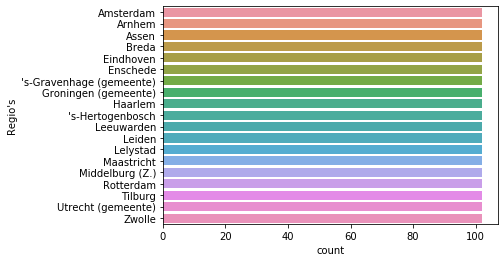

In [50]:
# Het laten zien van hoevaak een regio voorkomt in de dataset.
sb.countplot(y="Regio's", data=data_vg)

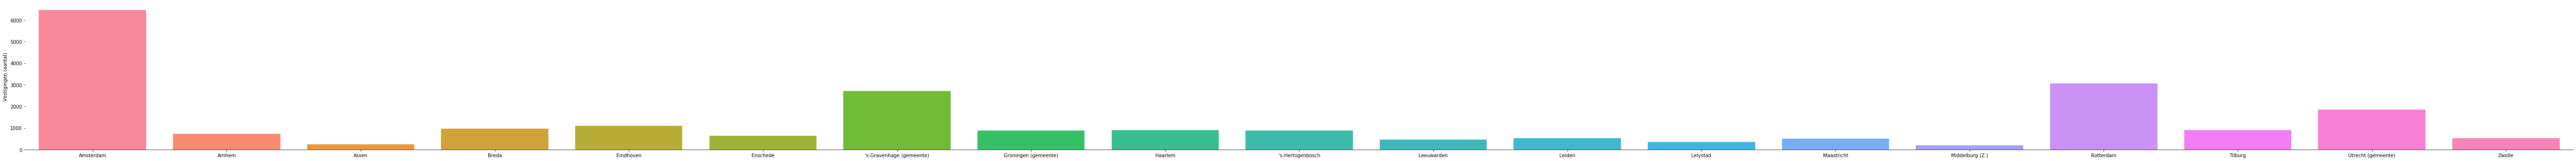

In [51]:
g = sb.catplot(x="Regio's", y="Vestigingen (aantal)",
                data=data_vg, saturation=10,
                kind="bar", ci=None, aspect=15)
(g.set_axis_labels("", "Vestigingen (aantal)")
  .set_titles("{col_name} {col_var}")
  .despine(left=True))

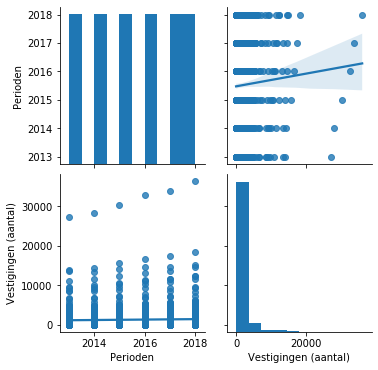

In [52]:
sb.pairplot(data_vg, kind="reg")

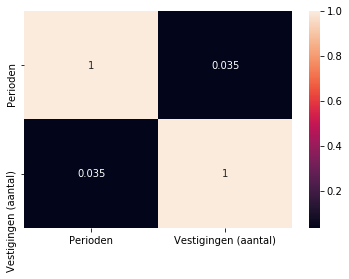

In [53]:
sb.heatmap(data_vg.corr(), annot=True)

### Samenvatting

Er zijn nu 2 datasets:
- `data_vg` is de 'standaard' dataframe met alle kolommen en waardes die compleet zijn.
- `groepeerde_data_vg` is de **gegroepeerde** dataset, gegroepeerd op de kolommen `Regio's` en `Perioden`.

# Data Preparation

Tijdens de analyse van de benodigde data worden de datasets `data_vg` en `groepeerde_data_vg` gebruikt. Van deze dataset wordt de data vanaf het jaar 2013 t/m 2018 gebruikt. De jaren 2019 en 2020 zijn wel beschikbaar, maar nog niet volledig.

Om te bepalen welke data gebruikt dient te worden, wordt er gekeken naar hoe de data aan de data mining goals kan voldoen. De data mining goal is: **Het verhogen van succesvolle woningzoekers die op zoek zijn naar een woonplek**.

De `data_vg` focust zich op het zoeken van mogelijke werkplekken van een woningzoekende in de ideale regio. De user story die beantwoordt dient te worden met de `data_vg` is **Als bezoeker wil ik graag dat werkgelegenheid mee wordt geteld in de resultaten, zodat ik kan de hoeveelheid mogelijke werkplekken per regio als resultaat zie**.

De meest recente data van `data_vg` wordt gebruikt om deze user story te beantwoorden. Deze nieuwe dataframe zal `data_vg_2018` heten.

Voor de volledigheid wordt voor elke periode een eigen dataframe gemaakt, in de syntax van de dataframe wordt dit weergegeven door `data_vg_[jaartal]`.

Ook wordt er een dataframe `data_pc` toegevoegd aan `data_vg`, zodat per regio de plaats, gemeente en provincie wordt weergegeven.

## Select Data

Van `data_vg_2018` worden alle kolommen gebruikt voor het beantwoorden van de user story.

Van `data_pc` wordt een aantal kolommen gebruikt, namelijk:
- `Plaats`.
- `Gemeente`.
- `Provincie`.



In [54]:
data_pc.columns

Index(['Regio's', 'Provincie'], dtype='object')

In [55]:
data_pc

,Regio's,Provincie
0,Appingedam,Groningen
1,Bedum,Groningen
2,Bellingwedde,Groningen
3,Ten Boer,Groningen
4,Delfzijl,Groningen
...,...,...
454,Venlo,Limburg
455,Venray,Limburg
456,Voerendaal,Limburg
457,Weert,Limburg


## Clean Data

In dit onderdeel wordt gekeken welke acties moeten worden ondernomen om de data op te schonen. Er wordt bijvoorbeeld gekeken naar rare waardes, aanpassingen in de records of overige acties.

In [56]:
# Unieke waarden in de verschillende kolommen van data_vg
test = ["Bedrijfstakken/branches SBI 2008", "Perioden", "Regio's", "Vestigingen (aantal)"]
for i in test:
    print(i, data_vg[i].unique())

Bedrijfstakken/branches SBI 2008 ['A Landbouw, bosbouw en visserij' 'B Delfstoffenwinning' 'C Industrie'
 'D Energievoorziening' 'E Waterbedrijven en afvalbeheer'
 'F Bouwnijverheid' 'G Handel' 'H Vervoer en opslag' 'I Horeca'
 'J Informatie en communicatie' 'K Financiële dienstverlening'
 'L Verhuur en handel van onroerend goed'
 'M Specialistische zakelijke diensten'
 'N Verhuur en overige zakelijke diensten' 'R Cultuur, sport en recreatie'
 'S Overige dienstverlening' 'U Extraterritoriale organisaties']
Perioden [2013 2014 2015 2016 2017 2018]
Regio's ['Amsterdam' 'Arnhem' 'Assen' 'Breda' 'Eindhoven' 'Enschede'
 "'s-Gravenhage (gemeente)" 'Groningen (gemeente)' 'Haarlem'
 "'s-Hertogenbosch" 'Leeuwarden' 'Leiden' 'Lelystad' 'Maastricht'
 'Middelburg (Z.)' 'Rotterdam' 'Tilburg' 'Utrecht (gemeente)' 'Zwolle']
Vestigingen (aantal) [   95   100   105   110   120    50    55    65    75    80   220   215
   225    40    45   150   145   155   175   185   190  1540  1480  1490
  1555  1640

Uit de vorige functie is te herlijden dat:
- `Bedrijfstakken/branches SBI 2008` heeft geen opmerkelijke waarden. Alle records zijn volgens hetzelfde format ingevuld.
- `Perioden` is gereed voor gebruik.
- `Regio's` heeft een aantal dubbele waarden, maar die worden weer gescheiden door de afkorting van de province van de Regio.
- `Vestigingen (aantal)` heeft een opmerkelijke notatie die op basis van vorige functie anders word weergegeven dan in de tabelweergave. De waarden zijn echter correct en hetzelfde, maar met een andere notatie. Het valt op dat er in deze kolom een NaN waarde zit, dat dient aangepast te worden.

In [57]:
# Controleren op de lege waardes
data_vg_incl_provincie.isna().sum()

NameError: name 'data_vg_incl_provincie' is not defined

In [58]:
# Invullen van de Na/NaN waarden in kolom Vestigingen (aantal) door 0
data_vg2 = data_vg["Vestigingen (aantal)"].fillna(0)
data_vg2

0        95
1       100
2       105
3       105
4       110
       ... 
1933      0
1934      0
1935      0
1936      0
1937      0
Name: Vestigingen (aantal), Length: 1938, dtype: int64

## Construct data

Om de data bruikbaar te maken voor user input in het formulier, wordt een classificatie aangebracht aan het aantal vestigingen. De waarde van deze classificatie zal bepaald worden door de uitkomst van data_vg.describe() uit de data understanding. De klassen zijn:
- `Laag`.
- `Middel`.
- `Hoog`.

Er wordt nog gewerkt aan een klasse `Geen` om de sectoren met 0 vestigingen te onderscheiden van de klasse `Laag`.

In [59]:
data_vg_incl_provincie = pd.merge(data_vg, data_pc, left_on="Regio's", right_on="Regio's")
data_vg_incl_provincie

,Bedrijfstakken/branches SBI 2008,Perioden,Regio's,Vestigingen (aantal),Provincie
0,"A Landbouw, bosbouw en visserij",2013,Amsterdam,95,Noord-Holland
1,"A Landbouw, bosbouw en visserij",2014,Amsterdam,100,Noord-Holland
2,"A Landbouw, bosbouw en visserij",2015,Amsterdam,105,Noord-Holland
3,"A Landbouw, bosbouw en visserij",2016,Amsterdam,105,Noord-Holland
4,"A Landbouw, bosbouw en visserij",2017,Amsterdam,110,Noord-Holland
...,...,...,...,...,...
1933,U Extraterritoriale organisaties,2014,Zwolle,0,Overijssel
1934,U Extraterritoriale organisaties,2015,Zwolle,0,Overijssel
1935,U Extraterritoriale organisaties,2016,Zwolle,0,Overijssel
1936,U Extraterritoriale organisaties,2017,Zwolle,0,Overijssel


In [60]:
data_vg_incl_provincie = movecol(data_vg_incl_provincie, cols_to_move=['Provincie'], ref_col="Regio's", place='After')

data_vg_incl_provincie

,Bedrijfstakken/branches SBI 2008,Perioden,Regio's,Provincie,Vestigingen (aantal)
0,"A Landbouw, bosbouw en visserij",2013,Amsterdam,Noord-Holland,95
1,"A Landbouw, bosbouw en visserij",2014,Amsterdam,Noord-Holland,100
2,"A Landbouw, bosbouw en visserij",2015,Amsterdam,Noord-Holland,105
3,"A Landbouw, bosbouw en visserij",2016,Amsterdam,Noord-Holland,105
4,"A Landbouw, bosbouw en visserij",2017,Amsterdam,Noord-Holland,110
...,...,...,...,...,...
1933,U Extraterritoriale organisaties,2014,Zwolle,Overijssel,0
1934,U Extraterritoriale organisaties,2015,Zwolle,Overijssel,0
1935,U Extraterritoriale organisaties,2016,Zwolle,Overijssel,0
1936,U Extraterritoriale organisaties,2017,Zwolle,Overijssel,0


In [61]:
werkgelegenheid_groupby = data_vg_incl_provincie.groupby(['Provincie',"Regio's", 'Perioden', 'Bedrijfstakken/branches SBI 2008']).sum()

werkgelegenheid_groupby

Vestigingen (aantal)
Provincie    Regio's   Perioden Bedrijfstakken/branches SBI 2008                             
Drenthe      Assen     2013     A Landbouw, bosbouw en visserij                            65
                                B Delfstoffenwinning                                        5
                                C Industrie                                               160
                                D Energievoorziening                                        0
                                E Waterbedrijven en afvalbeheer                            10
...                                                                                       ...
Zuid-Holland Rotterdam 2018     M Specialistische zakelijke diensten                    14655
                                N Verhuur en overige zakelijke diensten                  2910
                                R Cultuur, sport en recreatie                            5440
                                S Overige dienstverlening                                3330
                                U Extraterritoriale organisaties                            0

[1938 rows x 1 columns]

In [62]:
np.set_printoptions(threshold=np.inf)

min_max_scaler = preprocessing.MinMaxScaler()

aantal_vestigingen_minmax = min_max_scaler.fit_transform(data_vg_incl_provincie[["Vestigingen (aantal)"]])
werkgelegenheid_groupby["Aantal_vestigingen_genormaliseerd"] = aantal_vestigingen_minmax

werkgelegenheid_groupby

Vestigingen (aantal)  \
Provincie    Regio's   Perioden Bedrijfstakken/branches SBI 2008                                
Drenthe      Assen     2013     A Landbouw, bosbouw en visserij                            65   
                                B Delfstoffenwinning                                        5   
                                C Industrie                                               160   
                                D Energievoorziening                                        0   
                                E Waterbedrijven en afvalbeheer                            10   
...                                                                                       ...   
Zuid-Holland Rotterdam 2018     M Specialistische zakelijke diensten                    14655   
                                N Verhuur en overige zakelijke diensten                  2910   
                                R Cultuur, sport en recreatie                            5440   
                                S Overige dienstverlening                                3330   
                                U Extraterritoriale organisaties                            0   

                                                                         Aantal_vestigingen_genormaliseerd  
Provincie    Regio's   Perioden Bedrijfstakken/branches SBI 2008                                            
Drenthe      Assen     2013     A Landbouw, bosbouw en visserij                                   0.002618  
                                B Delfstoffenwinning                                              0.002756  
                                C Industrie                                                       0.002893  
                                D Energievoorziening                                              0.002893  
                                E Waterbedrijven en afvalbeheer                                   0.003031  
...                                                                                                    ...  
Zuid-Holland Rotterdam 2018     M Specialistische zakelijke diensten                              0.000000  
                                N Verhuur en overige zakelijke diensten                           0.000000  
                                R Cultuur, sport en recreatie                                     0.000000  
                                S Overige dienstverlening                                         0.000000  
                                U Extraterritoriale organisaties                                  0.000000  

[1938 rows x 2 columns]

De data van data_vg_2018 wordt gecategoriseerd op een `Laag`, `Middel` of `Hoog` aantal vestigingen in een bepaalde branche.

In [63]:
#data_vg_2018v2.drop(columns=["Klasse vestigingsaantal"])
vestigingen = werkgelegenheid_groupby["Vestigingen (aantal)"]

# Gebruik de aantallen die bij vg_data.describe() staan
werk_25 = vestigingen.quantile(q=.25)
werk_50 = vestigingen.quantile(q=.5)
werk_75 = vestigingen.quantile(q=.75)

# Gebruik de aantallen die bij vg_data.describe() staan
m1 = np.logical_and(vestigingen < werk_25, vestigingen != 0)
m2 = np.logical_and(vestigingen >  werk_25, vestigingen < werk_50)
m3 = np.logical_and(vestigingen >  werk_50, vestigingen < werk_75)
m4 = vestigingen > werk_75

werkgelegenheid_groupby["Vestigingen Klasse"] = np.select([m1,m2,m3,m4], ['Laag','Middel','Middel-Hoog','Hoog'], default='Geen')

werkgelegenheid_groupby

Vestigingen (aantal)  \
Provincie    Regio's   Perioden Bedrijfstakken/branches SBI 2008                                
Drenthe      Assen     2013     A Landbouw, bosbouw en visserij                            65   
                                B Delfstoffenwinning                                        5   
                                C Industrie                                               160   
                                D Energievoorziening                                        0   
                                E Waterbedrijven en afvalbeheer                            10   
...                                                                                       ...   
Zuid-Holland Rotterdam 2018     M Specialistische zakelijke diensten                    14655   
                                N Verhuur en overige zakelijke diensten                  2910   
                                R Cultuur, sport en recreatie                            5440   
                                S Overige dienstverlening                                3330   
                                U Extraterritoriale organisaties                            0   

                                                                         Aantal_vestigingen_genormaliseerd  \
Provincie    Regio's   Perioden Bedrijfstakken/branches SBI 2008                                             
Drenthe      Assen     2013     A Landbouw, bosbouw en visserij                                   0.002618   
                                B Delfstoffenwinning                                              0.002756   
                                C Industrie                                                       0.002893   
                                D Energievoorziening                                              0.002893   
                                E Waterbedrijven en afvalbeheer                                   0.003031   
...                                                                                                    ...   
Zuid-Holland Rotterdam 2018     M Specialistische zakelijke diensten                              0.000000   
                                N Verhuur en overige zakelijke diensten                           0.000000   
                                R Cultuur, sport en recreatie                                     0.000000   
                                S Overige dienstverlening                                         0.000000   
                                U Extraterritoriale organisaties                                  0.000000   

                                                                        Vestigingen Klasse  
Provincie    Regio's   Perioden Bedrijfstakken/branches SBI 2008                            
Drenthe      Assen     2013     A Landbouw, bosbouw en visserij                       Laag  
                                B Delfstoffenwinning                                  Laag  
                                C Industrie                                         Middel  
                                D Energievoorziening                                  Geen  
                                E Waterbedrijven en afvalbeheer                       Laag  
...                                                                                    ...  
Zuid-Holland Rotterdam 2018     M Specialistische zakelijke diensten                  Hoog  
                                N Verhuur en overige zakelijke diensten               Hoog  
                                R Cultuur, sport en recreatie                         Hoog  
                                S Overige dienstverlening                             Hoog  
                                U Extraterritoriale organisaties                      Geen  

[1938 rows x 3 columns]

# Uitkomst Analyse

Uit de analyse van deze notebook, wordt gekeken naar de requirements uit de User Input die de user story nodig heeft. Hieruit wordt geadviseerd welke opties de user moet kunnen invoeren in het formulier.

Vervolgens wordt er een advies gegeven wat voor beschrijvende statistieken en voorspellende aspecten uit de dataset toegepast kunnen worden, zodat ook die bijbehorende user stories uitgevoerd kunnen worden op de huidige dataset.

## User input in het formulier
De huidige user story heeft als resultaat een aantal voorstellen voor verwerking in het formulier. De user story is:
- **Als bezoeker wil ik graag dat werkgelegenheid mee wordt geteld in de resultaten, zodat ik kan de hoeveelheid mogelijke werkplekken per regio als resultaat zie**.

De dataset werkt met een classificatie van het aantal vestigingen per Regio per Bedrijfsbranche. Het aantal vestigingen zijn mogelijke werkplekken waar de user zou kunnen werken.

### Advies Formulier
In het formulier is het belangrijk dat de user een voorkeur voor bedrijfsbranche kan aanvinken. Dit zou bijvoorbeerld een lijstje met checkboxes kunnen zijn, zodat de user eventueel meerdere branches kan selecteren. Als extra optie kan de user aangeven welke klasse aan mogelijkheden het best bij de user past in bijvoorbeeld een drop down menu. Sommige gebruikers willen graag zo veel mogelijk opties zien, terwijl er ook gebruikers zijn die het fijner vinden om een geringe aantal opties te zien verschijnen.

### Advies Beschrijvende statistieken en voorspellende aspecten
De data in de analyse is gebaseerd op de periode 2018. Er is veel meer data beschikbaar van de perioden voor 2018 en een nog niet volledig overzicht van de jaren 2019 en 2020.

Voor het uitwerken van user stories over het beschrijvende gedeelte van deze dataset, kan gekeken worden naar de perioden voor 2018 en hier beschrijvende statistieken op uitvoeren. Er zou bijvoorbeeld een mooi overzicht van de ontwikkelingen van het aantal vestigingen van een bepaalde branche in een regio als overzicht gegeven kunnen worden.

Op basis van deze historische data kan ook een invulling gegeven worden aan het voorspellende aspect van de werkgelegenheid.